In [1]:
from helpers import load_csv_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
data_path='data/dataset'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

print("Number of samples of train: ", x_train.shape[0])
print("Number of features: ", x_train.shape[1])
print("Number of samples of test: ", x_test.shape[0])
print("Data type x_train:", x_train.dtype) #float64
print("Data type y_train:", y_train.dtype) #int64

Number of samples of train:  328135
Number of features:  321
Number of samples of test:  109379
Data type x_train: float64
Data type y_train: int64


variables' type:

Feature  0:    51 valori unici → numerical 
Feature  1:    11 valori unici → categorical nominal
Feature  2:   414 valori unici → numerical 
Feature  3:    11 valori unici → categorical nominal
Feature  4:    26 valori unici → numerical 
Feature  5:     2 valori unici → categorical binary
Feature  6:     2 valori unici → categorical binary
Feature  7:  9736 valori unici → numerical 
Feature  8:  9736 valori unici → numerical 
Feature  9:     2 valori unici → categorical binary
Feature 10:     3 valori unici → categorical nominal
Feature 11:     2 valori unici → categorical binary
Feature 12:     2 valori unici → categorical binary
Feature 13:     3 valori unici → categorical nominal
Feature 14:     3 valori unici → categorical nominal
Feature 15:    15 valori unici → categorical nominal
Feature 16:    11 valori unici → categorical nominal
Feature 17:    10 valori unici → categorical nominal
Feature 18:     2 valori unici → categorical binary
Feature 19:     2 valori unici → categorical

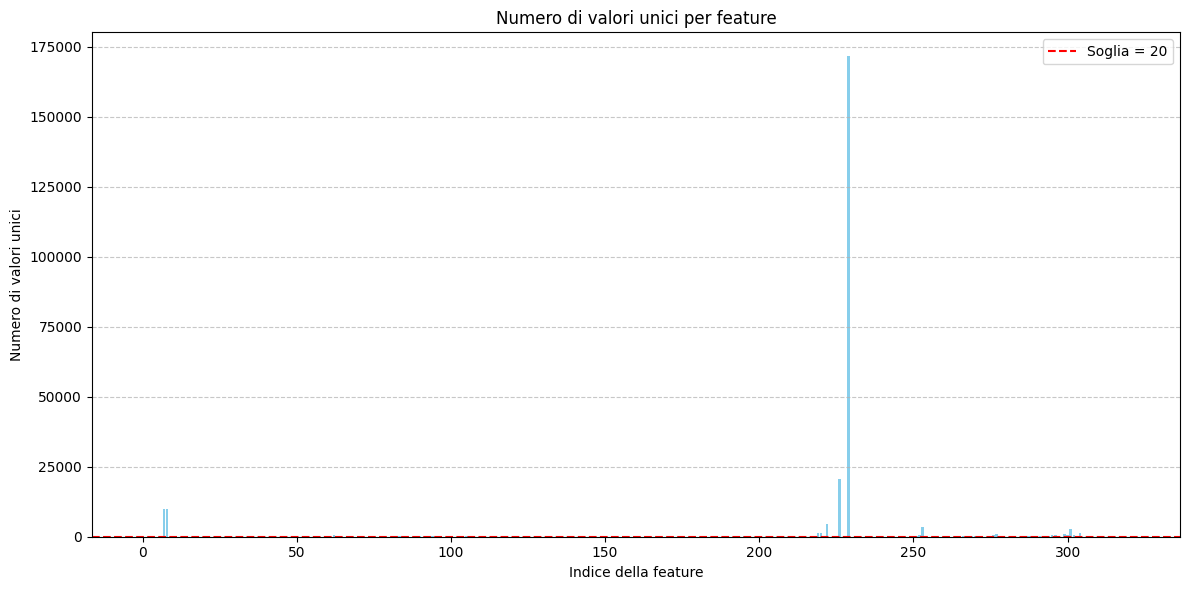

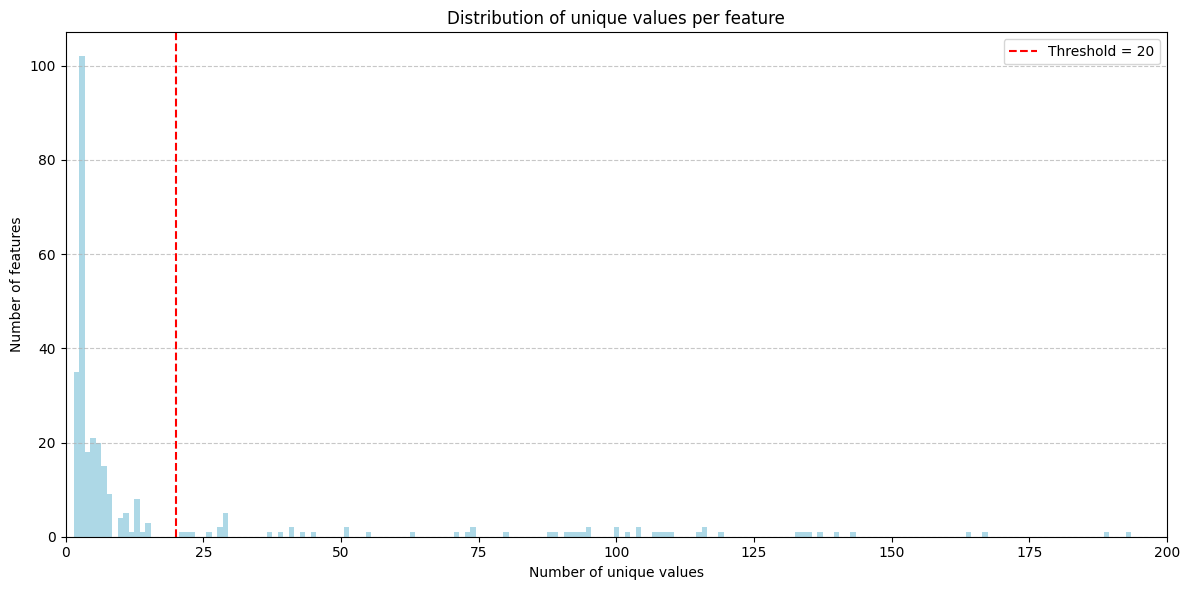

In [10]:
# Soglia per definire se una feature è categorica
categorical_threshold = 20

# Liste per salvare i risultati
categorical_features = []
continuous_features = []
unique_counts = []
binary_feature=[]
ordinal_feature=[]
nominal_feature=[]
one_feature=[]


# Check if values are integers (common for categorical)
is_integer_like = np.all(np.equal(np.mod(x_train, 1), 0))
special_codes=[7,9,77,88, 99] #PROBLEM: should not know the special codes until later when filtering based on the "deviation"

# Analisi delle feature
for i in range(x_train.shape[1]):
    
    col = x_train[:, i]
    count = len(np.unique(col))
    unique_counts.append(count)
    #calculating how many values are unique

    if count <= categorical_threshold:#if less than the threshold than categorical 
        categorical_features.append(i)
        label = 'categorical'

        # Enhanced ordinal check that handles special codes by removing them 
        meaningful_values = np.array([v for v in col if v not in special_codes]) #removing special codes
        sorted_meaningful = np.sort(np.unique(meaningful_values), axis=0) #selecting only the present unique values
        #print (sorted_meaningful)
            
        if len(sorted_meaningful) == 2:
            binary_feature.append(i)
            subtype = 'binary'

        elif len(sorted_meaningful)>2:

            diff_meaningful=np.diff(sorted_meaningful)
            is_consecutive = np.median(diff_meaningful) #control variable to check if ordinal or not
            #even non ordinal variables are saved as consecutive numbers 

            #print(diff_meaningful)

            if is_consecutive==1:
                ordinal_feature.append(i)
                subtype = 'ordinal'
                #special_codes_present = [code for code in special_codes if code in col]
            else:
                nominal_feature.append(i)
                subtype = 'nominal'
                #special_codes_present = [code for code in special_codes if code in col]
                #PROBLEM: ordinal values does not exactly mean ordinal feature, for example race 
        else:
            one_feature.append(i)
            subtype = 'one value'  
            #special_codes_present = [code for code in special_codes if code in col]

    else:
        continuous_features.append(i)
        label = 'numerical'
        subtype=''

    print(f"Feature {i:2}: {count:5} valori unici → {label} {subtype}")

# Riepilogo
print(f"\n Totale feature categoriche (<= {categorical_threshold} unique): {len(categorical_features)}")
print(f" Totale feature continue    (>  {categorical_threshold} unique): {len(continuous_features)}")
print(f"\n Totale feature categoriche ordinali: {len(ordinal_feature)}")
print(f" Totale feature categoriche binarie: {len(binary_feature)}")
print(f"\n Totale feature categoriche nominali: {len(nominal_feature)}")
print(f" Totale feature categoriche one value: {len(one_feature)}")


# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(unique_counts)), unique_counts, color='skyblue')
plt.axhline(y=categorical_threshold, color='red', linestyle='--', label=f'Soglia = {categorical_threshold}')
plt.xlabel('Indice della feature')
plt.ylabel('Numero di valori unici')
plt.title('Numero di valori unici per feature')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#2nd plot: marti's last version
# Build histrogram
unique_counts = np.array(unique_counts)
unique_vals, counts = np.unique(unique_counts, return_counts=True)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(unique_vals, counts, color='lightblue', width=1.0)
plt.axvline(x=categorical_threshold, color='red', linestyle='--', label=f'Threshold = {categorical_threshold}')
plt.xlabel('Number of unique values')
plt.xlim(right=200)
plt.xlim(left=0)
plt.ylabel('Number of features')
plt.title('Distribution of unique values per feature')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


cleaning non-meaningful values and nan:

In [11]:
#cleaning non-meaningful values 

#1st step: create an auxiliary variable 

for i in range(x_train.shape[1]):
    
    col = x_train[:, i]#fixing i-th column 


    #mean_aux=np.mean(aux_col)
    #std_aux=np.std(aux_col)


#compare with a metrics and substitute with NaN if out of the metric 
#    for j in range (len(col)):

        #if binary directly should not consider any other values 
    if subtype=='binary':
        bin_mask = (col != 1) & (col != 2)  
        x_train[bin_mask, i] = np.nan

    else: #non binary, more values
        aux_col=np.sort(col) # creazione della variabile ausiliaria ordinata su cui calcolare la mediana 

        median_aux=np.median(aux_col)
        q1=np.percentile(aux_col, 25)
        q3=np.percentile(aux_col, 75)
        iqr_aux=q3-q1
        upper_bound = median_aux+iqr_aux

        mask = (col>upper_bound)
        x_train[mask,i]=np.nan

#nan feature have to be dropped 
# Drop feature if at least 40% are NaN values
valid_cols = np.where(np.isnan(x_train).sum(axis=0) < 0.4 * x_train.shape[0])[0]
x_train_new_clean = x_train[:, valid_cols]
print(x_train_new_clean.shape)

# For other columns, NaN are replaced with the median
col_median = np.nanmedian(x_train, axis = 0)  
inds =np.where(np.isnan(x_train_new_clean))
x_train_new_clean[inds] = col_median[inds[1]]

(328135, 157)


verifying with prior knowledge of non-meaningful values:

In [12]:
#cleaning non-meaningful values - tentativo con conoscenza a priori

#1st step: create an auxiliary variable 

for i in range(x_train.shape[1]):
    
    col_check = x_train[:, i]#sto fixing colonna i 

    mask = (col_check==7)|(col_check==9)|(col_check==77)|(col_check==88)|(col_check==99)

    x_train[mask, i] = np.nan


#nan feature have to be dropped 
# Drop feature if at least 40% are NaN values
valid_cols = np.where(np.isnan(x_train).sum(axis=0) < 0.4 * x_train.shape[0])[0]
x_train_new_clean_2 = x_train[:, valid_cols]
print(x_train_new_clean_2.shape)

# For other columns, NaN are replaced with the median
col_median = np.nanmedian(x_train, axis = 0)  
inds_2 =np.where(np.isnan(x_train_new_clean_2))
x_train_new_clean_2[inds_2] = col_median[inds_2[1]]

(328135, 157)


Data cleaning: highly correlated features

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


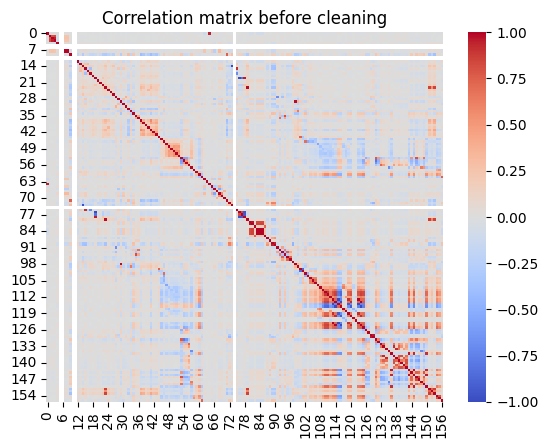

New shape: (328135, 131)


In [13]:
# Cross-correlation among features
def corrcoef(X):
    n_features = X.shape[1]
    corr = np.empty((n_features, n_features))
    for i in range(n_features):
        for j in range(i, n_features):
            corr_ij = np.corrcoef(X[:, i], X[:, j])[0, 1]       # np.corrcoef returns correlation matrix of two 1D-arrays, corr_ij is in position [0,1]            
            corr[i, j] = corr_ij
            corr[j, i] = corr_ij  
    return corr

corr_matrix = corrcoef(x_train_new_clean)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix before cleaning')
plt.show()

# Drop features if correlation > 0.9

non_valid_col = set()  # Use set to avoid duplicates
for i in range(x_train_new_clean.shape[1]):
    for j in range(i + 1, x_train_new_clean.shape[1]):
        if abs(corr_matrix[i, j]) > 0.9:
            non_valid_col.add(j)  # Drop j, keep i
x_train_new = np.delete(x_train_new_clean, list(non_valid_col), axis=1)     # Remove column
print(f"New shape: {x_train_new.shape}")

Classes distribution in y_train

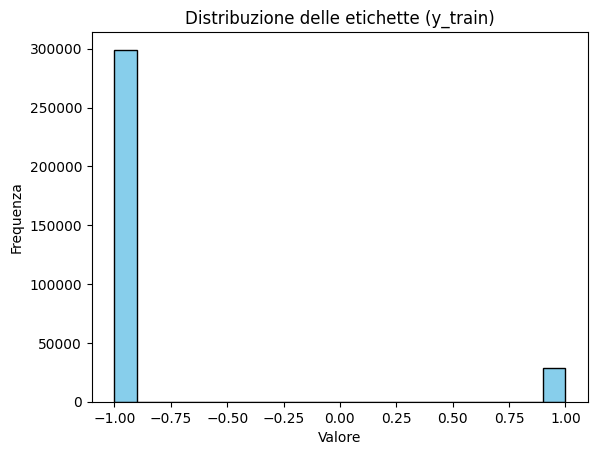

In [14]:
plt.hist(y_train, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuzione delle etichette (y_train)")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.show()

Z-score normalization

In [15]:
col_mean=np.mean(x_train_clean, axis=0)
col_sd=np.std(x_train_clean, axis=0)
print(f"Mean: {col_mean[0:5]}, Sd: {col_sd[0:5]}")
x_train_clean=(x_train_clean-col_mean)/col_sd
col_mean=np.mean(x_train_clean, axis=0)
col_sd=np.std(x_train_clean, axis=0)
print(f"Mean: {col_mean[0:5]}, Sd: {col_sd[0:5]}")


NameError: name 'x_train_clean' is not defined